In [13]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.1/452.1 kB 17.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Load data

In [6]:
# read filtered data from csv, using proper data type and with index
df_filtered = pd.read_csv('filtered_data.csv',index_col=0 ,dtype={'Age_Group': 'int64', 'C_EDU_Encoded': 'int64', 'C_HSE_Encoded': 'int64', 'C_OCC_Encoded': 'int64', 'INCM_TYP': 'int64', 'NUM_PRD': 'int64', 'IS_CASA': 'int64', 'CASATD_CNT': 'int64', 'CASA_DIFF': 'float64', 'DRvCR': 'float64', 'IS_TD': 'int64', 'IS_FUNDS': 'int64', 'IS_CC': 'int64', 'IS_LOAN': 'int64', 'CC_MTH_TRN_AMT_DIFF': 'int64', 'CC_LMT': 'int64', 'LoanAsset_ratio': 'float64', 'AssetvCValue': 'float64', 'Customer_Bank_engagement': 'float64', 'C_seg': 'int8'})
df_filtered.head()

,Age_Group,C_EDU_Encoded,C_HSE_Encoded,C_OCC_Encoded,INCM_TYP,NUM_PRD,IS_CASA,CASATD_CNT,CASA_DIFF,DRvCR,IS_TD,IS_FUNDS,IS_CC,IS_LOAN,CC_MTH_TRN_AMT_DIFF,CC_LMT,LoanAsset_ratio,AssetvCValue,Customer_Bank_engagement,C_seg
0,3,3,2,2,6,3,1,8,3988.20,1.020768e+06,1,0,1,0,0,34500,1.118960e+15,0.000000,0.000000,0
1,4,0,2,2,2,4,1,13,34422.30,8.326420e+00,1,0,1,0,8257,4000,6.272860e+15,0.083029,629581.713333,0
2,4,0,0,2,3,4,1,1,0.00,4.106600e-01,0,1,1,0,401,5000,6.416100e+14,0.505734,64127.580833,0
3,4,0,0,1,2,3,1,1,0.00,5.397180e+03,0,1,0,0,0,0,3.979200e+14,0.000000,0.000000,0
4,4,0,2,1,0,4,1,2,13740.68,3.607580e+03,0,1,0,0,0,0,6.725800e+14,0.000000,0.000000,0


In [7]:
# Split the data into features and target variable
X = df_filtered.drop('C_seg', axis=1)
y = df_filtered['C_seg']

### Define helper function for classifier reports

In [8]:
from typing import Any, List, Tuple
def get_hidden_affluent_customers(X: Any, y_true: Any, predicted_labels: Any) -> List:
    """
    Function to get the hidden affluent customers.

    Parameters:
    X (array-like): The input data.
    y_true (array-like): The true labels.
    predicted_labels (array-like): The predicted labels.

    Returns:
    hidden_affluent_customers_cv (array-like): The hidden affluent customers identified.
    """
    hidden_affluent_customers_cv = X[(predicted_labels == 0) & (y_true == 1)]  # identify original label as 1(Normal) and predicted label as 0(Hidden Affluent)
    print("\nNumber of hidden affluent customers identified:", len(hidden_affluent_customers_cv))

    return hidden_affluent_customers_cv


def get_classification_report(X: Any, y_true: Any, y_pred_proba: Any, threshold_in: float = 0.5, model_name: str = None, show_hidden_affluent: bool = True) -> Tuple[float, float, float, float, List]:
    """
    Get classification report for the model
    """
    positive_probs = y_pred_proba[:, 1]

    # Define threshold to classify as affluent customer
    threshold = threshold_in  # Example threshold (can be adjusted based on business requirements)
    # Classify instances based on threshold
    predicted_labels = (positive_probs >= threshold).astype(int)

    ### Code for classification evaluation metrics
    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, predicted_labels, pos_label=0)
    recall = recall_score(y_true, predicted_labels, pos_label=0)
    f1 = f1_score(y_true, predicted_labels, pos_label=0)

    # Print model name as big heading if provided
    if model_name:
        print("#" * 50)
        print(f'\t\t{model_name}')
        print("#" * 50)

    print("Cross-validated Precision for class 0 (affluent customers):", precision)
    print("Cross-validated Recall for class 0 (affluent customers):", recall)
    print("Cross-validated F1-score for class 0 (affluent customers):", f1)

    ### Code for Hidden Affluent Customers
    hidden_affluent_df = get_hidden_affluent_customers(X, y_true, predicted_labels)
    if show_hidden_affluent:
        print(hidden_affluent_df.head())

    #### Code for ROC-AUC curve
    # Compute ROC curve and ROC-AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    # Plot ROC curve with model name in title if provided
    plt.figure(figsize=(8, 6))
    if model_name:
        plt.title(f"Receiver Operating Characteristic (ROC) Curve - {model_name}")
    else:
        plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    return precision, recall, f1, roc_auc, hidden_affluent_df

    

### Train Random Forest Classifier

In [9]:
# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Make cross-validated predictions
y_pred_cv = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')

##################################################
		Random Forest Classifier
##################################################
Cross-validated Precision for class 0 (affluent customers): 0.6238339552238806
Cross-validated Recall for class 0 (affluent customers): 0.5119127356233854
Cross-validated F1-score for class 0 (affluent customers): 0.5623587533505019

Number of hidden affluent customers identified: 3226


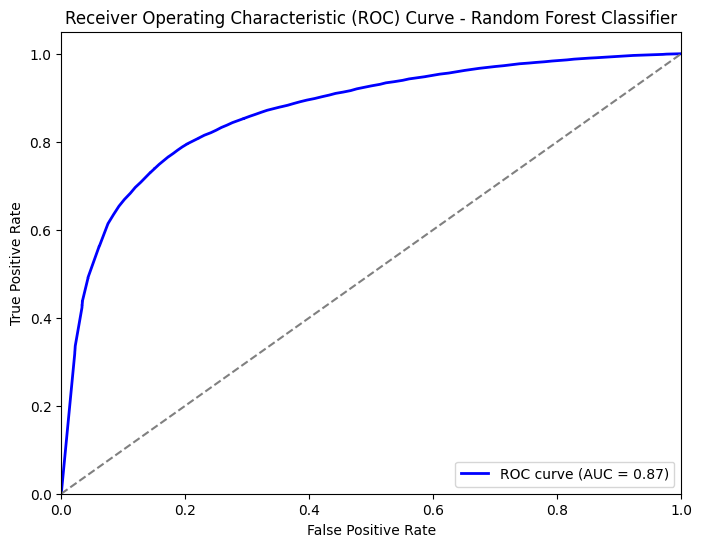

In [10]:
# get classification report
_ = get_classification_report(X,y, y_pred_cv,threshold_in=.50,model_name='Random Forest Classifier',show_hidden_affluent=False)

### Train XGBoost classifier, with GridSearchCV for hyperparameter tuning

In [ ]:
parameters = {
    'max_depth': [4, 8],  
    'learning_rate': [0.1, 0.05],  
    'n_estimators': [100, 200], 
    'subsample': [0.8, 1],  
    'colsample_bytree': [0.9, 1] ,
    'gamma': [0, 0.1],
    'reg_lambda': [1, 5],
    'reg_alpha': [0, 1]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(objective= 'binary:logistic',seed=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(xgb, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
best_params

In [11]:
best_params = {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}

##################################################
		XGBoost Classifier
##################################################
Cross-validated Precision for class 0 (affluent customers): 0.675573002405977
Cross-validated Recall for class 0 (affluent customers): 0.5104774662711702
Cross-validated F1-score for class 0 (affluent customers): 0.5815347721822542

Number of hidden affluent customers identified: 2562


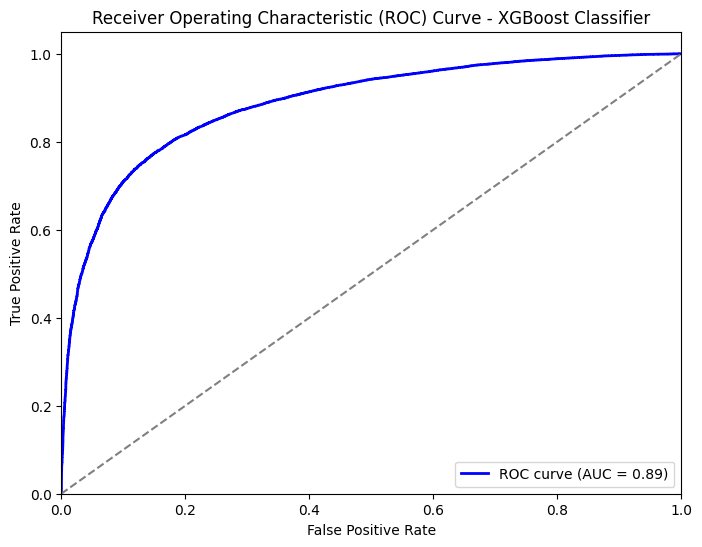

In [12]:
# Train and predict using the best parameters
xgb_best = XGBClassifier(objective= 'binary:logistic',seed=42,**best_params)
y_pred_xgb_proba = cross_val_predict(xgb_best, X, y, cv=5, method='predict_proba')

# get classification report
_ = get_classification_report(X,y, y_pred_xgb_proba,threshold_in=.50,model_name='XGBoost Classifier',show_hidden_affluent=False)

### Help understand Model prediction better using Shaply

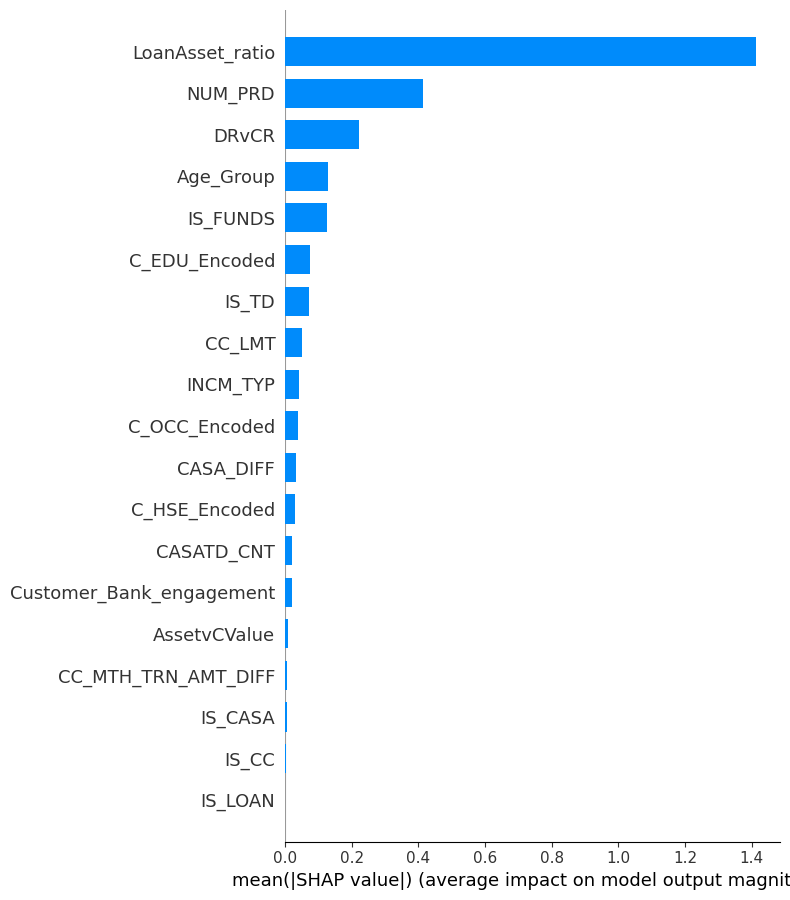

In [37]:
# use shaply to explain the model
import shap 
import warnings

shap.initjs()

# Train the model
xgb_best.fit(X, y)

# Create the explainer object
explainer = shap.TreeExplainer(xgb_best)

# Calculate Shap values
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

### To check decision Boundary for our prediction around probability (.45 -.50) and (.50-.55), what are our most important features in deciding
We've used, feature_order='hclust' to groups observations with similar prediction paths.
Insights:
1. (For .50-.55)There are not many outliers in the output, Effect of LoanAsset_ratio, IS_FUNDS, NUM_PRD immediately stand out .
2. (For .45-.50) Few outliers are present which will require further inspection of individual record, but effect of LoanAsset_ratio, IS_FUNDS, NUM_PRD is present for deciding at major level.
3. For lower probability to not predict Affluent category, LoanAsset_ratio, IS_FUNDS, NUM_PRD, AssetCvalue, and Education plays important factor.

(1463, 19)


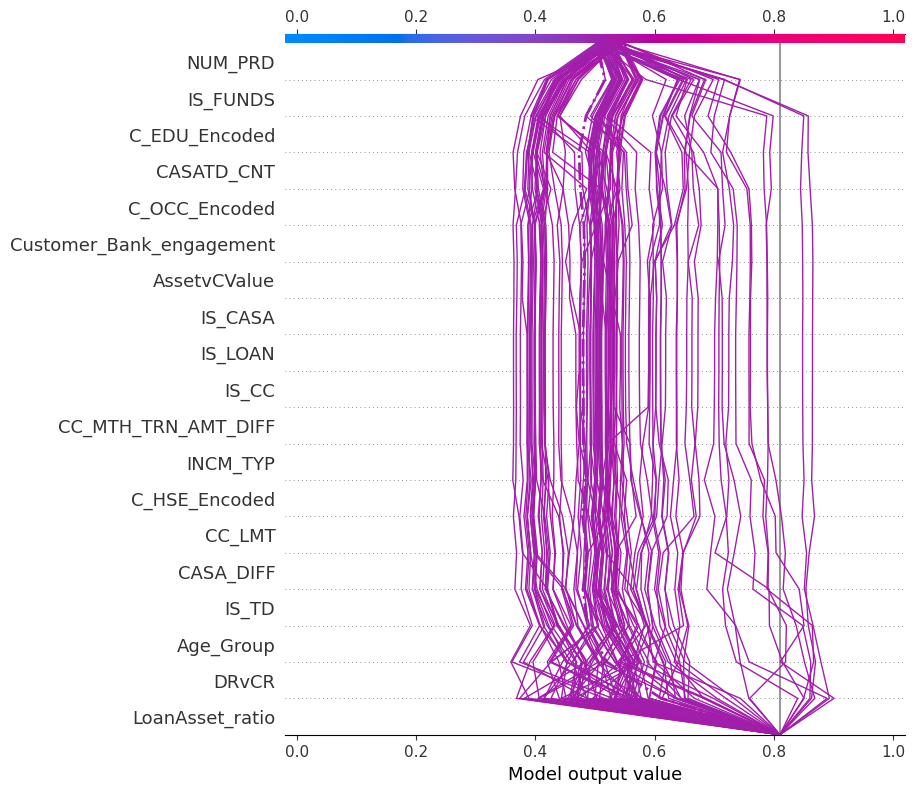

In [134]:
### For results interpretation and decision making between probability threshold of 0.50 and 0.55
y_pred = xgb_best.predict_proba(X)[:, 1]  # Get predictions on the probability scale.
T = X[(y_pred >= 0.50) & (y_pred <=.55)]  # Select the top 1% of customers with the highest probability of being affluent.
print(T.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[150:250,:]
shap.decision_plot(explainer.expected_value, sh, T, feature_order="hclust", link="logit", highlight=0)

(1463, 19)


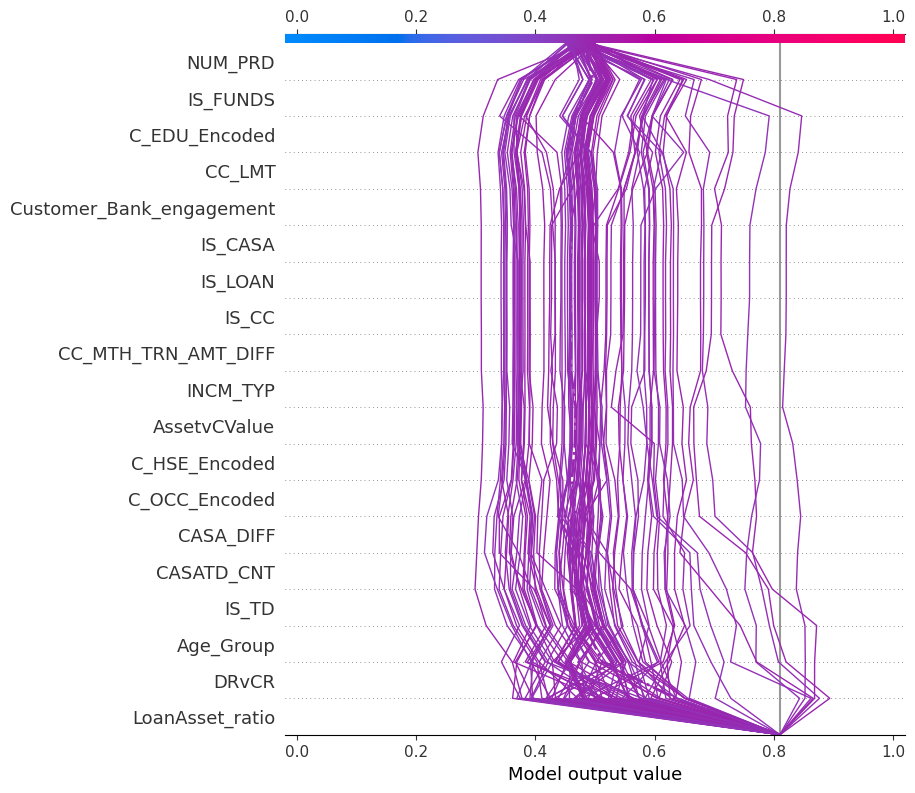

In [163]:
### For results interpretation and decision making between probability threshold of 0.45 and 0.50
# y_pred = xgb_best.predict_proba(X)[:, 1]  # Get predictions on the probability scale.
T_mid = X[(y_pred >= 0.45) & (y_pred <.50)]  # Select the top 1% of customers with the highest probability of being affluent.
print(T.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T_mid)[1200:1300,:]
r= shap.decision_plot(explainer.expected_value, sh, T_mid, feature_order="hclust",link='logit', highlight=0,return_objects=True)

### Look inside individual decision plot with most negative IS_FUNDS value in database, for given probability

In [169]:
import numpy as np
# Find the two observations with the most negative 'IS_FUNDS' SHAP values.
idx = np.argpartition(sh[:, T.columns.get_loc("IS_FUNDS")], 2)[0:1]

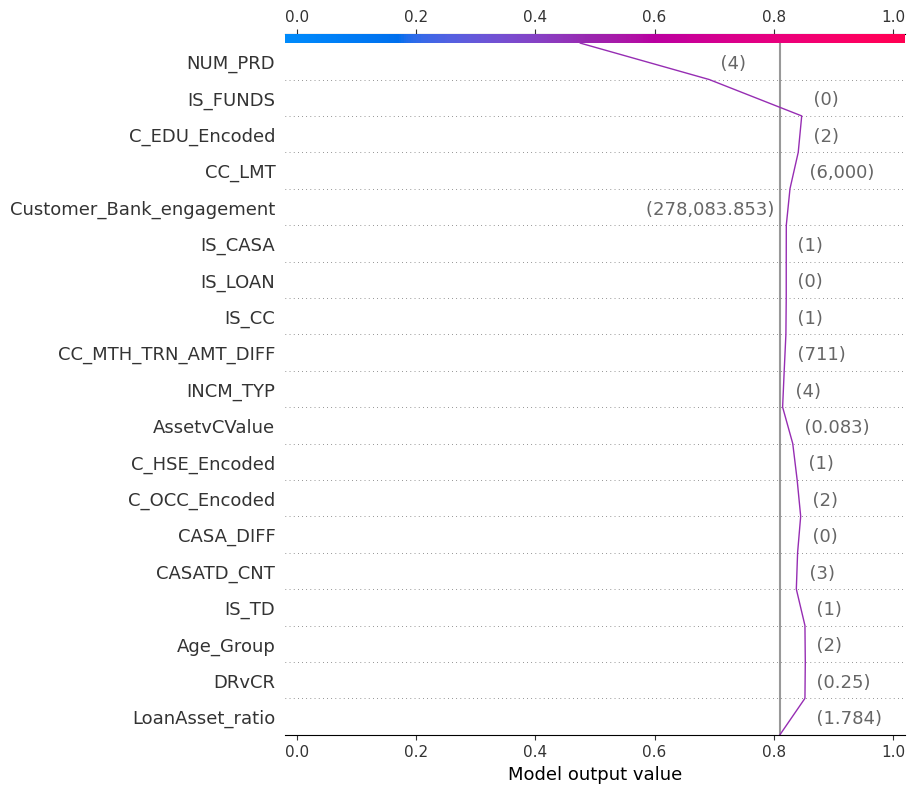

In [170]:
# Plot the observations individually with their corresponding feature values. The plots use the same feature order
# as the original plot.
for i in idx:
    shap.decision_plot(
        explainer.expected_value,
        sh[i],
        X.loc[T.index[i]],
        feature_order=r.feature_idx,
        xlim=r.xlim,
        link='logit'
    )

(288, 19)


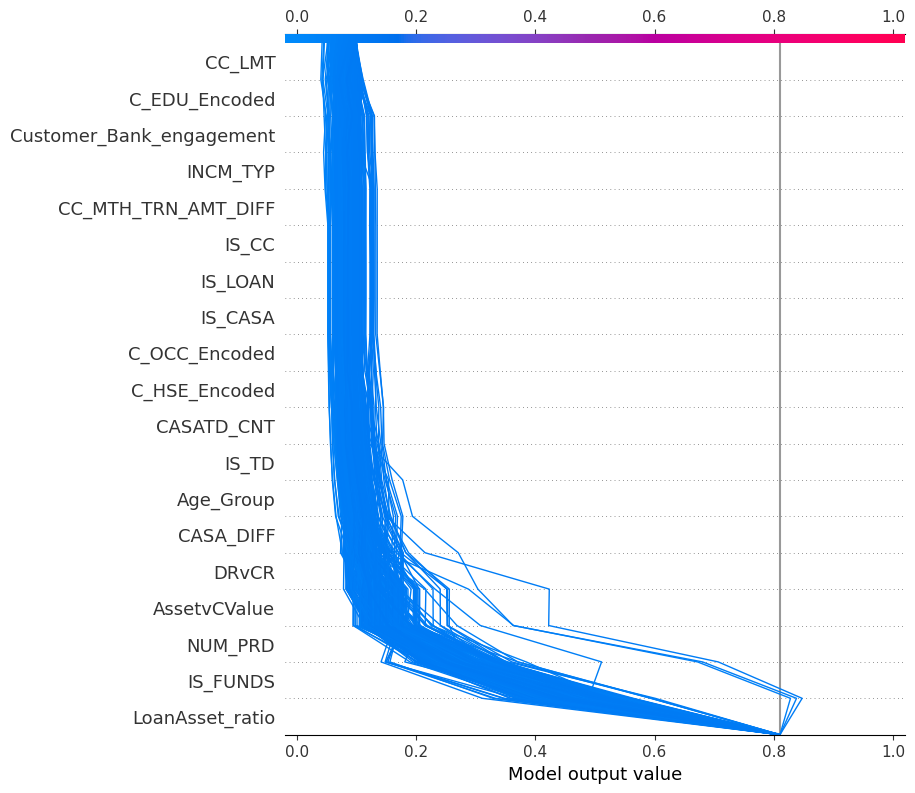

In [141]:
### For results interpretation and decision making between probability threshold of 0.01 and 0.1
# y_pred = xgb_best.predict_proba(X)[:, 1]  # Get predictions on the probability scale.
T_low = X[(y_pred >= 0.01) & (y_pred <= 0.1)]  # Select the top 1% of customers with the highest probability of being affluent.
print(T_low.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T_low)[0:500,:]
shap.decision_plot(explainer.expected_value, sh, T_low, feature_order="hclust", link="logit", highlight=0)

In [43]:
# Force plot of 1 individual record
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])


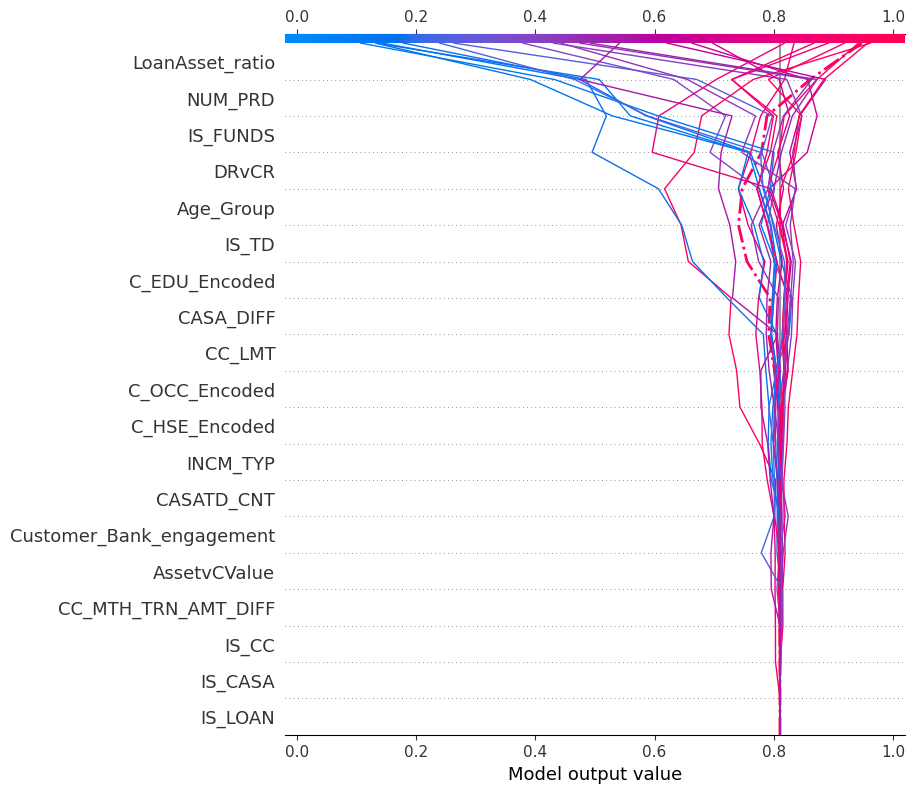

In [105]:
# Decision plot with random sample of X and shap values
shap.decision_plot(explainer.expected_value, shap_values[25:50,:], X, link='logit', highlight=0)